In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]

In [13]:
id_model_list = ["meta-llama/Meta-Llama-3-8B",
            "mistralai/Mistral-7B-v0.1",
            "EleutherAI/pythia-6.9b-deduped",
            "EleutherAI/pythia-160m-deduped",
            "EleutherAI/pythia-410m-deduped",
            "EleutherAI/pythia-1.4b-deduped",
            "EleutherAI/pythia-2.8b-deduped",
            "facebook/opt-6.7b",
            "gpt2",
            "gpt2-large",
            "gpt2-xl"
            ]
large_model_list = ["meta-llama/Meta-Llama-3-8B",
            "mistralai/Mistral-7B-v0.1",
            "EleutherAI/pythia-6.9b-deduped",
            "facebook/opt-6.7b"]
model_titles = {
    "meta-llama/Meta-Llama-3-8B": "Llama-3 8B",
    "mistralai/Mistral-7B-v0.1": "Mistral 7B",
    "EleutherAI/pythia-6.9b-deduped": "Pythia 6.9B",
    "EleutherAI/pythia-160m-deduped": "Pythia 160M",
    "EleutherAI/pythia-410m-deduped": "Pythia 410M",
    "EleutherAI/pythia-1.4b-deduped": "Pythia 1.4B",
    "EleutherAI/pythia-2.8b-deduped": "Pythia 2.8B",
    "facebook/opt-6.7b": "OPT 6.7B",
    "gpt2": "GPT-2 (124M)",
    "gpt2-large": "GPT-2 (774M)",
    "gpt2-xl": "GPT-2 (1.5B)"
}

In [14]:
cmp = {'meta-llama/Meta-Llama-3-8B': colors6[3], 'mistralai/Mistral-7B-v0.1': colors6[2], 'EleutherAI/pythia-6.9b-deduped': colors6[0],\
       'facebook/opt-6.7b': colors6[4]}

In [52]:
ids = {}; ids_shuffled = {}; logits_id = {}
losses = {};
tuned_entropy = {}; contextual_entropy = {};
rs_idx = 1
for model in id_model_list:
    ids[model] = np.load(f'Pile-Structured/{model}/gride.npy')[:, :, 0, rs_idx]
    losses[model] = np.load(f'Pile-Structured/{model}/losses.npy')
    if model != 'mistralai/Mistral-7B-v0.1': tuned_entropy[model] = np.load(f'Pile-Structured/{model}/entropy.npy')
    if model in large_model_list:
        ids_shuffled[model] = np.load(f'Pile-Shuffled/{model}/gride.npy')[:, :, 0, rs_idx].reshape(50, 20, 32)
    if model == 'meta-llama/Meta-Llama-3-8B': 
        logits_id[model_name] = np.load(f'Pile-Structured/{model}/logits_id.npy')[:, 0, rs_idx]
        contextual_entropy[model_name] = np.load(f'Pile-Structured/{model}/contextual_entropy.npy')

## Figure 1

In [44]:
TEST_INDX_SHUFFLE = 14
TEST_INDX_UNSHUFFLED = 686
subset_indices = np.load('../subset_indices.npy')

filtered_indices = np.load('../filtered_indices.npy')
assert subset_indices[TEST_INDX_SHUFFLE] == filtered_indices[TEST_INDX_UNSHUFFLED]

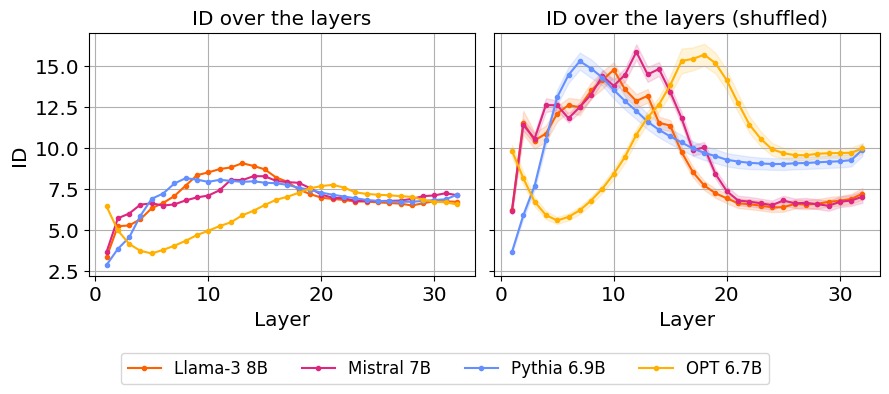

In [45]:

xrange = np.arange(1, num_layers + 1)
fig, axes = plt.subplots(1, 2, figsize = (9, 3.5), sharey = True)
for idx in range(2):
    
    ax = axes[idx]
    for jdx, model_name in enumerate(large_model_list):
        if idx == 0:
            op = ids[model_name][TEST_INDX_UNSHUFFLED]
            # print(op.shape)
            ax.set_title(f'ID over the layers',  fontsize = "x-large")
            ax.set_ylabel(f"ID", fontsize = "x-large")
            ax.plot(xrange, op, label = model_titles[model_name], color=cmp[model_name], marker = '.')

        if idx == 1:
            op = ids_shuffled[model_name][TEST_INDX_SHUFFLE]
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label = model_name, color=cmp[model_name], marker = '.')
            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmp[model_name], alpha=0.15)
            
            ax.set_title(f'ID over the layers (shuffled)',  fontsize = "x-large")
        

    ax.set_xlabel("Layer", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = 4,  fontsize = "large")
plt.savefig(f'figs/{subset_indices[TEST_INDX_SHUFFLE]}_avg_id_multiple_shuffles.png', bbox_inches='tight')
plt.show()

## Figure 2

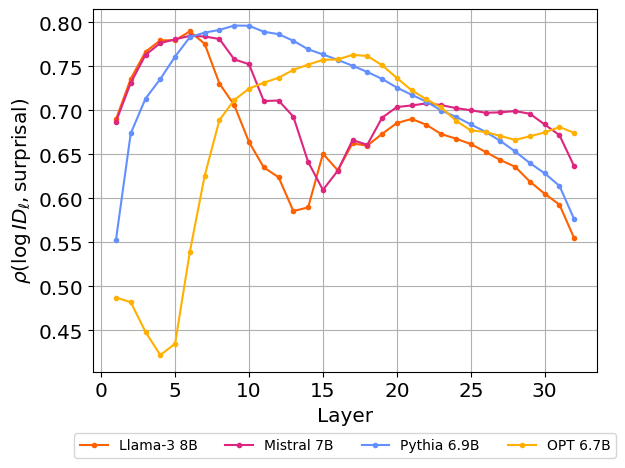

In [16]:
rs_idx = 1
for jdx, model_name in enumerate(large_model_list):
    id_model, loss_model = np.log(ids[model_name]), losses[model_name]
    num_layers = id_model.shape[1]
    pearson = [stats.pearsonr(id_model[:, lnum], loss_model).statistic for lnum in range(num_layers)]  
    plt.plot(np.arange(1, num_layers+1), pearson, label = model_titles[model_name], marker = '.', c = cmp[model_name])
    plt.ylabel("$\\rho(\log ID_{\ell}, \\text{surprisal})$", fontsize = "x-large")
    plt.xlabel("Layer", fontsize = "x-large")
plt.tick_params(labelsize = "x-large")
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize="medium")
plt.tight_layout()
plt.savefig(f'figs/log_id_loss_correlation_scaling_{2**(rs_idx + 1)}.png', bbox_inches='tight')


## Figure 3

In [46]:
def plot_scatter(arrx, arry, ax, fit_xy=False, fit_pearson=False, color = None):
    ax.scatter(arrx, arry, color = color, alpha = 0.7)
    
    if fit_xy:
        min_val = min(min(arrx), min(arry))
        max_val = max(max(arrx), max(arry))
        ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label="x = y")
        ax.legend(fontsize = "x-large")
    
    if fit_pearson:
        # Calculate Pearson correlation
        corr, pval = stats.pearsonr(arrx, arry)
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(arrx, arry)
        
        # Create x values for the fit line
        line_x = np.array([min(arrx), max(arrx)])
        
        # Calculate corresponding y values
        line_y = slope * line_x + intercept
        
        # Plot the fit line
        ax.plot(line_x, line_y, color='black', linestyle='--')
        bbox_props = dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white", alpha=0.9)
        if pval < 0.01:
            # Annotate with Pearson correlation and equation
            ax.annotate(f"$\\rho$ : {corr:.2f} (p < 0.01)",
                        # f"y = {slope:.2f}x + {intercept:.2f}", 
                        xy=(0.45, 0.95), xycoords='axes fraction', 
                        fontsize="x-large", verticalalignment='top', bbox = bbox_props)
        else:
            # Annotate with Pearson correlation and equation
            ax.annotate(f"$\\rho$ : {corr:.2f} (p = {pval:.2f})",
                        xy=(0.4, 0.95), xycoords='axes fraction', 
                        fontsize="x-large", verticalalignment='top', bbox = bbox_props)
    
    ax.grid(True)
    # ax.legend()
    

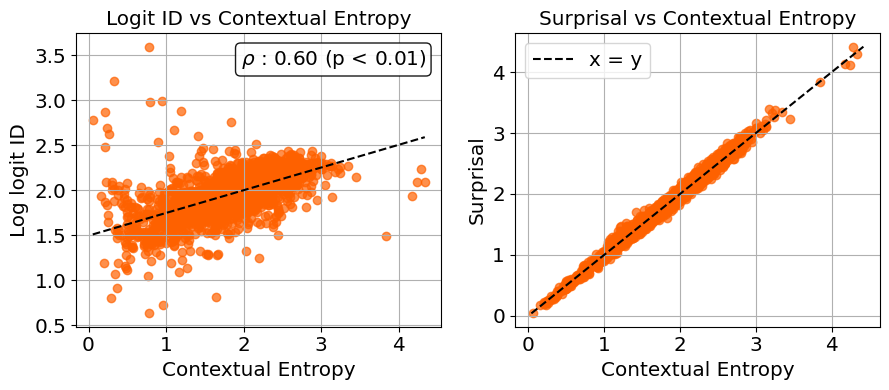

In [55]:
fig, axes = plt.subplots(1,2, figsize = (9, 4))
model_name = 'meta-llama/Meta-Llama-3-8B'
rs_idx = 1
for idx in range(2):
    ax = axes[idx]
    fit_xy = True
    fit_pearson = True
        
    if idx == 0:
        arrx = contextual_entropy[model_name]
        arry = np.log(logits_id[model_name])
        fit_xy = False
        
        ax.set_xlabel('Contextual Entropy', fontsize = "x-large")
        ax.set_ylabel('Log logit ID', fontsize = "x-large")
        ax.set_title(f'Logit ID vs Contextual Entropy', fontsize = "x-large")
        
        
    else:
        arrx = contextual_entropy[model_name]
        arry = losses[model_name]
        fit_pearson = False
        
        ax.set_xlabel('Contextual Entropy', fontsize = "x-large")
        ax.set_ylabel('Surprisal', fontsize = "x-large")
        
        ax.set_title(f'Surprisal vs Contextual Entropy', fontsize = "x-large")
        
    plot_scatter(arrx = arrx, arry = arry, ax = ax, fit_xy = fit_xy, fit_pearson = fit_pearson, color = cmp[model_name])
    
    ax.tick_params(which='both', labelsize="x-large")
    
plt.tight_layout()
plt.savefig(f'figs/logit_loss_{model_titles[model_name]}_softmax_scaling_{2**(idx + 1)}.png', bbox_inches='tight')

plt.show()

## Figure 4

In [ ]:
def plot_pearson(arrx, arry, ax, rel_depth = True, color = None):
    num_layers = arrx.shape[1]
    pearson = np.array([stats.pearsonr(arrx[:, lnum], arry[:, lnum]).statistic for lnum in range(num_layers)])  
    pvals = np.array([stats.pearsonr(arrx[:, lnum], arry[:, lnum]).pvalue for lnum in range(num_layers)])  
    if rel_depth :
        x_values = np.linspace(0, 1, num_layers)
        ax.set_xlabel("Relative Depth", fontsize="large")
    else:
        x_values = np.arange(1, num_layers + 1)
        ax.set_xlabel("Layer", fontsize="large")
        
    ax.plot(x_values, pearson, label=model_titles[model_name], marker='.', c  = color)
    significant_idx = pvals > 0.01
    if len(significant_idx) > 0:
        ax.scatter(x_values[significant_idx], pearson[significant_idx], color='black', marker='o', s=25, linewidth=1.5)

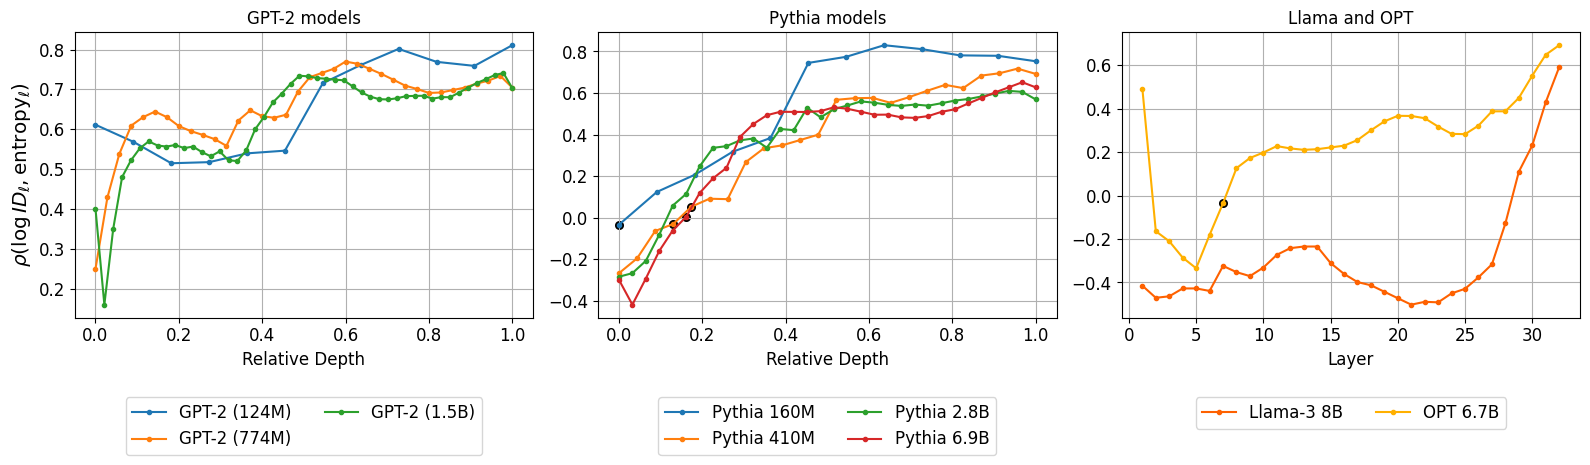

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # Three axes for the models
for idx in range(3):
    rel_depth = True
    ax = axes[idx]
    if idx == 0:  # For GPT-2 models
        new_models = ['gpt2', 'gpt2-large', 'gpt2-xl']   
        ax.set_title('GPT-2 models', fontsize="large")
        ax.set_ylabel("$\\rho(\log ID_{\ell}, \\text{entropy}_\ell)$", fontsize="x-large")
    if idx == 1:  # For Pythia family models
        new_models = ["EleutherAI/pythia-160m-deduped", "EleutherAI/pythia-410m-deduped",
             "EleutherAI/pythia-2.8b-deduped","EleutherAI/pythia-6.9b-deduped"]
        ax.set_title('Pythia models', fontsize="large")
            
    if idx == 2:  # For Other models (Llama, Pythia, Opt)
        new_models = ["meta-llama/Meta-Llama-3-8B", "facebook/opt-6.7b"]
        ax.set_title('Llama and OPT', fontsize="large")
        rel_depth = False 
        
            
    for jdx, model_name in enumerate(new_models):
        id_model, entropy_model = np.log(ids[model_name]), tuned_entropy[model_name]
        color = None
        if idx == 2: color = cmp[model_name] 
        plot_pearson(arrx = id_model, arry = entropy_model, ax = ax, rel_depth = rel_depth, color = color)


    

    ax.tick_params(labelsize="large")
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize="large")

plt.tight_layout()
plt.savefig(f'figs/tuned_correlation.png', bbox_inches='tight')